# Entrega GPU IV - Shared
### Filipe F. Borba  
### Insper
### Super Computação, Prof. Igor Montagner


## Introdução

O objetivo dessa entrega é comparar diversos algoritmos de multiplicação de matrizes para verificar a diferença das implementações em GPU. Com isso, foram utilizados vetores de tamanho size * size, onde size está em [128, 512, 1024]. Ao utilizar um vetor de tamanho 2048 o programa começava a demorar demais para as soluções mais fracas. A máquina utilizada foi uma p2.xlarge da AWS, que possui uma GPU NVIDIA Tesla K80.

## Entrega

In [1]:
%matplotlib inline
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
key = "/home/filipefborba/Documents/Keys/IgorNvidia.pem"
host = "ec2-user@ec2-54-80-199-115.compute-1.amazonaws.com" # MUDAR O IP AQUI
working_directory = "/home/ec2-user/borba/supercomp/15-gpu-IV/" # MUDAR A PASTA AQUI

In [3]:
# Realizar o build na máquina da aws.
print(subprocess.call(["ssh", "-i", key, host, "cd", working_directory, "&&", "mkdir", "build"]))
print(subprocess.call(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "cmake .."]))
print(subprocess.call(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "make", "-j4"]))

1
0
0


In [4]:
# Listar os executaveis
output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "ls"])
output = output.decode("utf-8").splitlines()
files = sorted([x for x in output if (x.startswith("naive") or x.startswith("par") or x.startswith("seq") or x.startswith("tiling"))])
files

['naive1024',
 'naive128',
 'naive2048',
 'naive512',
 'par1024',
 'par128',
 'par2048',
 'par512',
 'seq1024',
 'seq128',
 'seq2048',
 'seq512',
 'tiling1024',
 'tiling128',
 'tiling2048',
 'tiling512']

In [5]:
# Devolve o output e o tempo de execucao
def run_test(file):
    output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&",
                                 f"./{file}"])
    output = output.decode("utf-8").splitlines()
    
    filename = re.sub("\d+", "", file)
    vsize = re.sub("\D", "", file)
    print(f"--{file}------{vsize}--")
    print(output)
    return [filename, vsize, float(output[0][6:])]

In [6]:
# Tempo de Execução
data = []
for f in files:
    if (not f.endswith("2048")):
        data.append(run_test(f))

--naive1024------1024--
['Time= 24.552320']
--naive128------128--
['Time= 0.199008']
--naive512------512--
['Time= 3.257024']
--par1024------1024--
['Time= 0.000000']
--par128------128--
['Time= 0.000000']
--par512------512--
['Time= 0.000000']
--seq1024------1024--
['Time= 3447.623535']
--seq128------128--
['Time= 2.517536']
--seq512------512--
['Time= 351.397949']
--tiling1024------1024--
['Time= 8.90128']
--tiling128------128--
['Time= 0.15130']
--tiling512------512--
['Time= 1.24045']


In [7]:
# Converter us para ms
def fix_time(time):
    if (time.endswith("us")):
        return float(time[:-2])/1000
    elif (time.endswith("ms")):
        return float(time[:-2])
    elif (time.endswith("s")):
        return float(time[:-1])*1000
    else:
        print("time not us, ms or s")
        return 0

In [8]:
# Pegar nome e tempo de execucao
def get_name_and_time(output, name):
    if (name.startswith("tiling")):
        name = "multMat"
    if (name.startswith("naive")):
        name = "MatrixMulKernel"
    for s in output:
        found_name = s.find(name)
        if found_name != -1:
            result = s[found_name:found_name+len(name)]
            found_time = re.search('%(.*)s ', s)
            if (found_time == None):
                pass
            else:
                print(found_time.group(1).split()[0], result)
                return found_time.group(1).split()[0], result

In [9]:
# Tempos de alocacao e copia de memoria, alem de kernel.
def run_nvprof_test(file):
    output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&",
                                 "nvprof", f"./{file}"], stderr=subprocess.STDOUT)
    output = output.decode("utf-8").splitlines()
    
    filename = re.sub("\d+", "", file)
    vsize = re.sub("\D", "", file)
    print(f"--{file}------{vsize}--")
    kernel_time, kernel_name = get_name_and_time(output, str(file))
    htod_time, htod_name = get_name_and_time(output, "[CUDA memcpy HtoD]")
    dtoh_time, dtoh_name = get_name_and_time(output, "[CUDA memcpy DtoH]")
    malloc_time, malloc_name = get_name_and_time(output, "cudaMalloc")
    kernel_time = fix_time(kernel_time)
    htod_time = fix_time(htod_time)
    dtoh_time = fix_time(dtoh_time)
    malloc_time = fix_time(malloc_time)
    return [filename, vsize,
        kernel_time, kernel_name,
        htod_time, htod_name,
        dtoh_time, dtoh_name,
        malloc_time, malloc_name
           ]

In [10]:
gpu_files = [x for x in output if (x.startswith("naive") or x.startswith("tiling"))]
gpu_files

['naive1024',
 'naive128',
 'naive2048',
 'naive512',
 'tiling1024',
 'tiling128',
 'tiling2048',
 'tiling512']

In [11]:
data_gpu = []
for f in gpu_files:
    data_gpu.append(run_nvprof_test(f))

--naive1024------1024--
24.416ms MatrixMulKernel
1.1015ms [CUDA memcpy HtoD]
1.9737ms [CUDA memcpy DtoH]
122.84ms cudaMalloc
--naive128------128--
85.502us MatrixMulKernel
33.376us [CUDA memcpy HtoD]
11.071us [CUDA memcpy DtoH]
132.06ms cudaMalloc
--naive2048------2048--
196.62ms MatrixMulKernel
4.5355ms [CUDA memcpy HtoD]
11.525ms [CUDA memcpy DtoH]
131.71ms cudaMalloc
--naive512------512--
3.1277ms MatrixMulKernel
272.16us [CUDA memcpy HtoD]
134.56us [CUDA memcpy DtoH]
131.35ms cudaMalloc
--tiling1024------1024--
8.7563ms multMat
1.0927ms [CUDA memcpy HtoD]
1.7702ms [CUDA memcpy DtoH]
131.98ms cudaMalloc
--tiling128------128--
33.375us multMat
32.384us [CUDA memcpy HtoD]
10.880us [CUDA memcpy DtoH]
121.62ms cudaMalloc
--tiling2048------2048--
69.549ms multMat
4.5491ms [CUDA memcpy HtoD]
12.227ms [CUDA memcpy DtoH]
132.72ms cudaMalloc
--tiling512------512--
1.1244ms multMat
272.00us [CUDA memcpy HtoD]
134.78us [CUDA memcpy DtoH]
123.73ms cudaMalloc


# Resultados

Aqui estamos preocupados com a diferença de desempenho, então foram plotados gráficos para verificar a diferença entre as soluções.

In [22]:
df = pd.DataFrame(data, dtype=np.float64)
df = df.sort_values(by=[0, 1])
df

,0,1,2
1,naive,128.0,0.199008
2,naive,512.0,3.257024
0,naive,1024.0,24.552320
4,par,128.0,0.000000
5,par,512.0,0.000000
3,par,1024.0,0.000000
7,seq,128.0,2.517536
8,seq,512.0,351.397949
6,seq,1024.0,3447.623535
10,tiling,128.0,0.151300


In [23]:
df2 = pd.DataFrame(data_gpu, dtype=np.float64)
df2 = df2.sort_values(by=[0, 1])
df2

,0,1,2,3,4,5,6,7,8,9
1,naive,128.0,0.085502,MatrixMulKernel,0.033376,[CUDA memcpy HtoD],0.011071,[CUDA memcpy DtoH],132.06,cudaMalloc
3,naive,512.0,3.127700,MatrixMulKernel,0.272160,[CUDA memcpy HtoD],0.134560,[CUDA memcpy DtoH],131.35,cudaMalloc
0,naive,1024.0,24.416000,MatrixMulKernel,1.101500,[CUDA memcpy HtoD],1.973700,[CUDA memcpy DtoH],122.84,cudaMalloc
2,naive,2048.0,196.620000,MatrixMulKernel,4.535500,[CUDA memcpy HtoD],11.525000,[CUDA memcpy DtoH],131.71,cudaMalloc
5,tiling,128.0,0.033375,multMat,0.032384,[CUDA memcpy HtoD],0.010880,[CUDA memcpy DtoH],121.62,cudaMalloc
7,tiling,512.0,1.124400,multMat,0.272000,[CUDA memcpy HtoD],0.134780,[CUDA memcpy DtoH],123.73,cudaMalloc
4,tiling,1024.0,8.756300,multMat,1.092700,[CUDA memcpy HtoD],1.770200,[CUDA memcpy DtoH],131.98,cudaMalloc
6,tiling,2048.0,69.549000,multMat,4.549100,[CUDA memcpy HtoD],12.227000,[CUDA memcpy DtoH],132.72,cudaMalloc


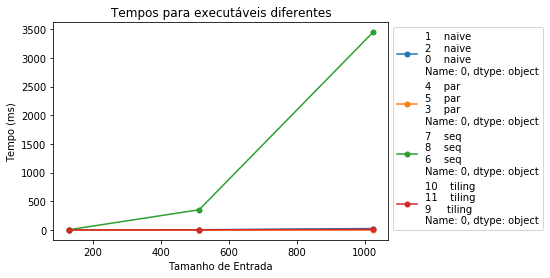

In [24]:
groups = df.groupby(0)

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group[1], group[2], marker='o', linestyle='-', ms=5, label=group[0])
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Tamanho de Entrada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

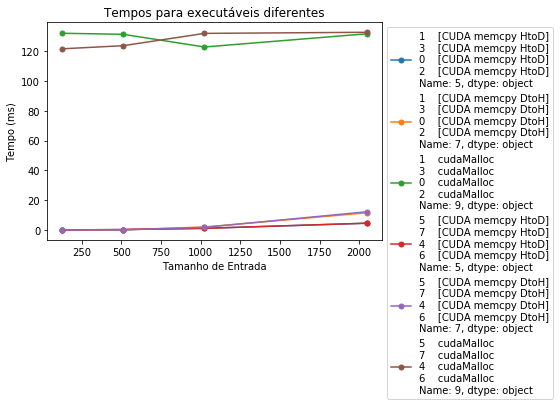

In [27]:
groups = df2.groupby(0)

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group[1], group[4], marker='o', linestyle='-', ms=5, label=group[5])
    ax.plot(group[1], group[6], marker='o', linestyle='-', ms=5, label=group[7])
    ax.plot(group[1], group[8], marker='o', linestyle='-', ms=5, label=group[9])
    
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Tamanho de Entrada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Como podemos verificar nos gráficos acima, o tempo de execução dos algoritmos que utilizam a GPU são muito menores, sendo o algoritmo de Tiling o mais eficiente. Isso ocorre pois a GPU é muito superior em realizar operações em paralelo e o Tiling é o algoritmo "esperto" para isso.  

Além disso, como podemos verificar nos tempos de alocação e cópia dos dois executáveis, o custo acaba não sendo tão relevante, chegando a ser próximo de constante. Isso nos indica que esses custos de alocação e cópia tem um overhead quase que fixo, assim, ao aproveitar isso e usar muitos dados, os tempos de execução ficam bem rápidos (e ao usar entradas pequenas e não aproveitar, esse custo fica bem mais evidente).